Upload the `utils.py` file to your runtime environment to use all the helper functions

In [6]:
from google.colab import files

uploaded = files.upload()

Saving utils.py to utils (1).py


In [7]:
from __future__ import print_function
import numpy as np
from utils import *

# To allow evaluators to see what you got
np.random.seed(677)

# Homework 2

## Part 1 - Implement Dropout and Normalization layers

In this exercise you will build on the code you developed in HW1, and observe how batch normalization and dropout help with training fully connected neural networks and improving their generalization performance. As in the previous homework you will implement these components from scratch using only `numpy`. To aid in this effort, we have provided you with some starter code. The starter code also contains the module definitions from the previous homework (`Module`, `Sequential`, `FullyConnected`, etc.). You may reuse your code from that submission, you do not need to duplicate effort.

You may complete this assignment on either Google Colab or your own machine. If you are using your own machine you will require a functioning `numpy` installation, and the `pickle` module.

### Code from HW1

Use your code from homework 1 (if it passed all the tests) to fill in the empty `Module`, `Sequential`, and other classes that you will need to build a fully connected network

In [8]:
# superclass of modules
class Module:
    """
    Module is a super class. It could be a single layer, or a multilayer perceptron.
    """

    def __init__(self):
        self.train = True
        return

    def forward(self, _input):
        """
        h = f(z); z is the input, and h is the output.

        Inputs:
        _input: z

        Returns:
        output h
        """
        pass

    def backward(self, _input, d_output):
        """
        Compute:
        gradient w.r.t. _input
        gradient w.r.t. trainable parameters

        Inputs:
        _input: z
        _gradOutput: dL/dh

        Returns:
        gradInput: dL/dz
        """
        pass

    def parameters(self):
        """
        Return the value of trainable parameters and its corresponding gradient (Used for grandient descent)

        Returns:
        params, gradParams
        """
        pass

    def training(self):
        """
        Turn the module into training mode. Need this for layers that
        have different behaviors at train and test time.
        """
        self.train = True

    def evaluate(self):
        """
        Turn the module into evaluation mode. Need this for layers that
        have different behaviors at train and test time.
        """
        self.train = False

In [9]:
class Sequential(Module):
    """
    Sequential provides a way to plug layers together in a feed-forward manner.
    """
    def __init__(self):
        Module.__init__(self)
        self.layers = []

    def add(self, layer):
        self.layers.append(layer) # Adding another layer at the end

    def size(self):
        return len(self.layers)

    def forward(self, _input):
        """
        Feed forward through all the layers, and return the output of the last layer
        """
        # self._inputs saves the input of each layer
        # self._inputs[i] is the input of i-th layer
        self._inputs = [_input]

        # YOUR CODE HERE
        for layer in self.layers:
            output = layer.forward(self._inputs[-1])  #  Output from the current layer
            self._inputs.append(output)  # Append the output to the list of inputs for the next layers

        # The last element of self._inputs is the output of last layer
        self._output = self._inputs[-1]
        return self._output

    def backward(self, _input, d_output):
        """
        Backpropogate through all the layers using chain rule.
        """

        self.d_inputs = [None] * (self.size() + 1)
        self.d_inputs[self.size()] = d_output

        # YOUR CODE HERE
        for i in range(self.size() - 1, -1, -1):
            d_input = self.layers[i].backward(self._inputs[i], self.d_inputs[i+1])
            self.d_inputs[i] = d_input
        self.d_input = self.d_inputs[0]
        return self.d_input

    def parameters(self):
        """
        Return trainable parameters and its corresponding gradient in a nested list
        """
        params = []
        d_params = []
        for m in self.layers:
            _p, _d = m.parameters()
            if _p is not None:
                params.append(_p)
                d_params.append(_d)
        return params, d_params

In [10]:
class FullyConnected(Module):
    """
    Fully connected linear layer
    y = Wx + b
    """
    def __init__(self, inputSize, outputSize):
        Module.__init__(self)

        """
        Initalization: Use the Xavier initialization scheme to
        set the standard deviation of the weights. We will use
        the uniform distribution instead of the normal distribution
        in order to avoid large weight values. Sometimes practitioners
        also use the truncated normal distribution for this purpose.
        """

        stdv = np.sqrt(2.0 / (inputSize + outputSize)) # YOUR CODE HERE

        self.weight = np.random.uniform(-stdv, stdv, (outputSize, inputSize))
        self.d_weight = np.zeros((outputSize, inputSize))
        self.bias = np.random.uniform(-stdv, stdv, outputSize)
        self.d_bias = np.zeros(outputSize)

    def forward(self, _input):
        """

        _input:
        N x inputSize matrix

        """
        self._output = np.dot(_input, self.weight.T) + self.bias # YOUR CODE HERE
        return self._output

    def backward(self, _input, d_out):
        """
        _input:
        N x inputSize matrix
        d_out:
        N x outputSize matrix
        """
        self.d_weight = np.dot(d_out.T, _input) # YOUR CODE HERE
        self.d_bias = np.sum(d_out, axis=0) # YOUR CODE HERE

        self.d_input = np.dot(d_out, self.weight) # YOUR CODE HERE
        return self.d_input

    def parameters(self):
        """
        Return weight and bias and their g
        """
        return [self.weight, self.bias], [self.d_weight, self.d_bias]

In [11]:
class ReLU(Module):
    """
    ReLU activation, no trainable parameters
    y = max(x, 0)
    """
    def __init__(self):
        Module.__init__(self)
        return

    def forward(self, _input):
        """
        _input:
        N x d matrix
        """
        self._output = np.maximum(0, _input)
        return self._output

    def backward(self, _input, d_out):
        """
        _input:
        N x d matrix

        d_out:
        N x d matrix
        """
        self.d_input = d_out * (_input > 0)
        return self.d_input

    def parameters(self):
        """
        No trainable parameters, return None
        """
        return None, None

In [12]:
class SoftMaxLoss:
    def __init__(self):
        return

    def forward(self, _input, _label):
        """
        Softmax and cross entropy loss layer. Should return a scalar, since it's a
        loss.

        _input: N x C
        _labels: N x C, one-hot

        Returns: loss (scalar)
        """
        #YOUR CODE HERE
        shift_input = _input - np.max(_input, axis=1, keepdims=True)

        # Softmax function
        exps = np.exp(shift_input)
        softmax_output = exps / np.sum(exps, axis=1, keepdims=True)

        # Cross-entropy loss
        self._output = -np.sum(_label * np.log(softmax_output + 1e-12)) / _input.shape[0]

        self.softmax_output = softmax_output

        return self._output

    def backward(self, _input, _label):
        self.d_input = (self.softmax_output - _label) / _input.shape[0] # YOUR CODE HERE
        return self.d_input

In [13]:
# Test softmaxloss, the relative error should be small enough
def test_sm():
    crit = SoftMaxLoss()
    gt = np.zeros((3, 10))
    gt[np.arange(3), np.array([1,2,3])] = 1
    x = np.random.random((3,10))
    def test_f(x):
        return crit.forward(x, gt)

    crit.forward(x, gt)

    d_input = crit.backward(x, gt)
    d_input_numeric = numeric_gradient(test_f, x, 1, 1e-6)
    # print(d_input)
    # print(d_input_numeric)
    print(relative_error(d_input, d_input_numeric, 1e-8))

test_sm()

5.966419986814647e-09


### Implement a `Dropout` layer (10 points)

Implement the forward and backward passes for a `Dropout` layer with drop rate `p`. Remember that Dropout has different behaviors when training and testing. Use the `Module.train` flag to monitor which mode you are in and deal with the forward/backward pass accordingly.



In [14]:
class Dropout:
    """
    A dropout layer
    """
    def __init__(self, p=0.5):
        self.p = p  # self.p is the dropout probability
        self.mask = None
        self.test = False

    # Method to set the module to test mode
    def set_test_mode(self, seed=677):
        self.test = True
        np.random.seed(seed)

    # Method to reset the module to training mode
    def reset_test_mode(self):
        self.test = False

    def forward(self, _input):
        if not self.test:
            self.mask = (np.random.rand(*_input.shape) > self.p).astype(int)
            self._output = _input * self.mask / (1 - self.p)
        else:
            self._output = _input
        return self._output

    def backward(self, _input, d_output):
        if not self.test:
            self.d_input = d_output * self.mask / (1 - self.p)
        else:
            self.d_input = d_output
        return self.d_input

    def parameters(self):
        """
        No trainable parameters.
        """
        return None, None

**Testing `Dropout` forward pass**

Test if your dropout layer maintains the mean of the input at the output during both training and evaluation modes

In [15]:
_input = np.random.randn(677, 677) + 10

for p in [0.25, 0.4, 0.7]:
    layer = Dropout(p=p)
    layer.reset_test_mode()
    output = layer.forward(_input)
    layer.set_test_mode()
    test_output = layer.forward(_input)

    print('Running tests with p = ', p)
    print('Mean of input: ', _input.mean())
    print('Mean of train-time output: ', output.mean())
    print('Mean of test-time output: ', test_output.mean())
    print('Fraction of train-time output set to zero: ', (output == 0).mean())
    print('Fraction of test-time output set to zero: ', (test_output == 0).mean())
    print()

Running tests with p =  0.25
Mean of input:  9.999152185692843
Mean of train-time output:  9.998711306354917
Mean of test-time output:  9.999152185692843
Fraction of train-time output set to zero:  0.2500496368329301
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  9.999152185692843
Mean of train-time output:  9.998322918728102
Mean of test-time output:  9.999152185692843
Fraction of train-time output set to zero:  0.4001012373207892
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  9.999152185692843
Mean of train-time output:  9.977958084373933
Mean of test-time output:  9.999152185692843
Fraction of train-time output set to zero:  0.7006168058316188
Fraction of test-time output set to zero:  0.0



**Testing `Dropout` backward pass**

Test if your dropout layer maintains the mean of the input at the output during both training and evaluation modes

In [16]:
def test_module(model, name):

    crit = TestCriterion()
    gt = np.random.random((3,10))
    x = np.random.random((3,10))
    def test_f(x):
        return crit.forward(model.forward(x), gt)

    d_input = model.backward(x, crit.backward(model.forward(x), gt))
    d_input_num = numeric_gradient(test_f, x, 1, 1e-6)
    print(f'Testing {name}: ', relative_error(d_input, d_input_num, 1e-8))


# Test fully connected
model = FullyConnected(10, 20)
test_module(model, 'Fully Connected')

# Test ReLU
model = ReLU()
test_module(model, 'ReLU')

# Test Dropout
model = Dropout()
model.set_test_mode()
model.set_test_mode()
test_module(model, 'Dropout')

# Test Sequential
model = Sequential()
model.add(FullyConnected(10, 20))
model.add(ReLU())
model.add(Dropout(p=0.4))
model.layers[-1].set_test_mode()
test_module(model, 'Sequential Model')


Testing Fully Connected:  1.396632565242596e-07
Testing ReLU:  7.360228254783035e-10
Testing Dropout:  7.360228254783035e-10
Testing Sequential Model:  1.5183623357528896e-08


### Implement a `Batch Normalization` layer (20 points)

Implement the forward and backward passes for a `BatchNormalization` layer. Remember that Batch Normalization has different behaviors when training and testing. Use the `Module.train` flag to monitor which mode you are in and deal with the forward/backward pass accordingly.

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$,

we first calculate the mean $\mu$ and variance $v$.
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

The batch norm operation is a little complicated. Remember to write down the computation graph (similar to the one given below), and track all the nodes and the forward and backward passes.

![image](batchnorm_graph.png)



In [17]:
class BatchNormalization(Module):
    """
    A Batch Normalization layer
    """

    def __init__(self, inputSize, eps=1e-5, momentum=0.9, gamma=None, beta=None):
        Module.__init__(self)
        self.dim = inputSize
        self.eps = eps

        self.gamma = np.ones(self.dim) if gamma is None else gamma
        self.beta = np.zeros(self.dim) if beta is None else beta

        self.d_gamma = np.zeros(self.dim)
        self.d_beta = np.zeros(self.dim)

        # Estimate a running mean and variance during train time for use during test time

        # During test time, normalize using the running_mean and running_var rather than the
        # test batch statistics

        # During train time, the momentum parameter is used to update the running mean and variance as follows

        ###################################################################################################
        ## self.running_mean = self.momentum * self.running_mean + (1.-self.momentum) * self.sample_mean ##
        ## self.running_var = self.momentum * self.running_var + (1.-self.momentum) * self.sample_var    ##
        ###################################################################################################

        # Running mean and variance
        self.momentum = momentum
        self.running_mean = np.zeros(self.dim)
        self.running_var = np.zeros(self.dim)

    def forward(self, _input):
        self._input = _input
        self.N = _input.shape[0]

        if self.training:
            # Calculate batch mean and variance
            self.batch_mean = np.mean(_input, axis=0)
            self.batch_var = np.var(_input, axis=0)

            # Update running mean and variance
            self.running_mean = self.momentum * self.running_mean + (1. - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1. - self.momentum) * self.batch_var

            self.normalized_input = (_input - self.batch_mean) / np.sqrt(self.batch_var + self.eps)

            # Scale and shift normalized input
            self._output = self.gamma * self.normalized_input + self.beta
        else:
            # Normalize input using running mean and variance during test time
            self.normalized_input = (_input - self.running_mean) / np.sqrt(self.running_var + self.eps)

            # Scale and shift normalized input
            self._output = self.gamma * self.normalized_input + self.beta

        return self._output

    def backward(self, _input, d_output):
        # Calculate gradients of gamma and beta
        self.d_gamma = np.sum(d_output * self.normalized_input, axis=0)
        self.d_beta = np.sum(d_output, axis=0)

        # Calculate gradient of loss with respect to normalized input
        d_normalized_input = d_output * self.gamma

        # Calculate gradients of mean and variance
        d_mean = np.sum(d_normalized_input, axis=0) * -1 / np.sqrt(self.batch_var + self.eps)
        d_var = np.sum(d_normalized_input * (_input - self.batch_mean) * -0.5 * (self.batch_var + self.eps)**-1.5, axis=0)

        # Calculate gradient of loss with respect to input
        self.d_input = d_normalized_input / np.sqrt(self.batch_var + self.eps) + \
                       d_var * 2 * (_input - self.batch_mean) / self.N + \
                       d_mean / self.N

        return self.d_input

    def parameters(self):
        """
        Return gamma, beta and their gradients
        """
        return [self.gamma, self.beta], [self.d_gamma, self.d_beta]

**Testing `BatchNormalization` forward pass**

Test if your Batch Normalization layer computes a normalized version of the input during the training mode

In [18]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network.
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print("means: ", np.mean(a, axis=0))
print("stds: ", np.std(a, axis=0))


# Means should be close to zero and stds close to one.
print('After batch normalization (gamma=1, beta=0)')
layer = BatchNormalization(D3)
layer.training()
a_norm = layer.forward(a)
print("means: ", np.mean(a_norm, axis=0))
print("stds: ", np.std(a_norm, axis=0))

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])

# Now means should be close to beta and stds close to gamma.
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
layer = BatchNormalization(D3, gamma=gamma, beta=beta)
layer.training()
a_norm = layer.forward(a)
print("means: ", np.mean(a_norm, axis=0))
print("stds: ", np.std(a_norm, axis=0))


Before batch normalization:
means:  [17.13579212 -4.72569817  4.36429068]
stds:  [33.81218256 31.88628844 24.39843426]
After batch normalization (gamma=1, beta=0)
means:  [ 6.71684930e-17  1.54321000e-16 -6.05071548e-17]
stds:  [1.         1.         0.99999999]
After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
means:  [11. 12. 13.]
stds:  [1.         1.99999999 2.99999997]


**Testing `BatchNormalization` backward pass**

Test if your Batch Normalization layer computes the right derivatives wrt the input

In [19]:
# Test Batch Norm
model = BatchNormalization(10)
model.training()
test_module(model, 'Batch Normalization')

# Test Sequential
model = Sequential()
model.add(FullyConnected(10, 20))
model.add(ReLU())
model.add(BatchNormalization(20))
test_module(model, 'Sequential Model with BN')


Testing Batch Normalization:  8.609024808506067e-08
Testing Sequential Model with BN:  1.7255765281397808e-07


Test if your Batch Normalization layer computes the right derivatives wrt the parameters

In [20]:
model = BatchNormalization(10)
model.training()

crit = TestCriterion()
gt = np.random.random((3,10))
x = np.random.random((3,10))

gamma = np.random.rand(10)
beta = np.zeros(10)

def f_gamma(gamma, model=model, x=x):
    model.gamma = gamma
    return crit.forward(model.forward(x), gt)

def f_beta(beta, model=model, x=x):
    model.beta = beta
    return crit.forward(model.forward(x), gt)

d_input = model.backward(x, crit.backward(model.forward(x), gt))
params, d_params = model.parameters()

d_gamma, d_beta = d_params
d_gamma_num = numeric_gradient(lambda g: f_gamma(g, model=model, x=x), gamma, 1, 1e-6)
d_beta_num = numeric_gradient(lambda b: f_beta(b, model=model, x=x), beta, 1, 1e-6)

print('Gamma error: ', relative_error(d_gamma, d_gamma_num, 1e-8))
print('Beta error: ', relative_error(d_beta, d_beta_num, 1e-8))

Gamma error:  3.3791222974730163e-10
Beta error:  6.988901124005461e-11


### Regularization Experiment (10 points)

Use the dataset from the previous homework assignment (a subset of Fashion MNIST) to train a network with dropout and without dropout. The `pickle` file containing this data set can be downloaded [here](https://www.dropbox.com/scl/fi/mxxg0k6x8q17feef2bvwg/fashion_mnist_small.pkl?rlkey=kb2j5zfqs6qen19jxs2f5g69z&dl=0). Put the data file in a convenient location, and make sure you include the path in the cell below.

The dataset contains a training set of $8000$ examples, validation set of $2000$ examples, and test set of $1000$ examples. The data consists of small $28 \times 28$ images that have been centered, scaled, and flattened into $784$ dimensional vectors with zero mean and unit variance.

In [21]:
from google.colab import files
uploaded = files.upload()

Saving fashion_mnist_small.pkl to fashion_mnist_small.pkl


In [22]:
filename = 'fashion_mnist_small.pkl'
X_train, y_train, X_val, y_val, X_test, y_test = load_fmnist_data(filename)

#### Build Models with and without Dropout

Modify the build model method from the previous assignment to include a `dropout_p` keyword argument that can be passed on to Dropout layers. Since `dropout_p` is the probability of dropping a neuron, if it is $0$, then you should not include any dropout layers. If it is larger than zero, include a dropout layer after every ReLU nonlinearity. All dropout layers should have the same dropout parameter.

In [41]:
def build_model(input_size, hidden_sizes, output_size, activation_func='ReLU', dropout_p=0.5):
    """
    Build the model:
    input_size: the dimension of input data
    hidden_sizes: the dimension of all hidden layers. Include as many hidden layers as are there in this list
    output_size: the output size of final layer.
    activation_func: ReLU
    dropout_p: Dropout parameter - probability of dropping a neuron. setting to zero disables dropout
    """
    model = Sequential()

    # Add the first hidden layer connected to the input
    model.add(FullyConnected(input_size, hidden_sizes[0]))
    if activation_func == 'ReLU':
        model.add(ReLU())

    # Add dropout layer if dropout_p > 0
    if dropout_p > 0:
        model.add(Dropout(p=dropout_p))

    # Add any additional hidden layers with dropout if specified
    for i in range(1, len(hidden_sizes)):
        model.add(FullyConnected(hidden_sizes[i-1], hidden_sizes[i]))
        if activation_func == 'ReLU':
            model.add(ReLU())

        # Add dropout layer if dropout_p > 0
        if dropout_p > 0:
            model.add(Dropout(p=dropout_p))

    # Output layer
    model.add(FullyConnected(hidden_sizes[-1], output_size))

    return model


In [42]:
# -- training options
trainopt = {
    'lr': .001,   # initial learning rate
    'maxiter': 20000,   # max number of iterations (updates) of SGD
    'display_iter': 500,  # display batch loss every display_iter updates
    'batch_size': 100,
    'lr_decay': .5, # when dropping lr, multiply it by this number (e.g., .5 means halve it)
    'lr_decay_interval': .25  #
}

NFEATURES = X_train.shape[1]
NCLASSES = 10
hidden_sizes = [500,500]
# Play around with choices of dropout probability
dropout_params = [0., 0.25]

results = {}

for p in dropout_params:
    model = build_model(NFEATURES, hidden_sizes, NCLASSES, dropout_p=p)
    criterion = SoftMaxLoss()

    print(f'Model with dropout parameter {p} has {model.size()} layers.')

    # -- model trained on large train set
    best_model, min_val_err, train_errors, val_errors, val_losses = train(model, criterion, X_train, y_train, X_val, y_val, trainopt)

    results[p] = {'model': best_model, 'train_errors': train_errors, 'val_errors': val_errors, 'val_losses': val_losses}


Model with dropout parameter 0.0 has 5 layers.
       0 batch loss: 2.310 train error: 85.462 val error: 84.750
     500 batch loss: 1.898 train error: 43.888 val error: 45.300
    1000 batch loss: 1.506 train error: 37.775 val error: 38.250
    1500 batch loss: 1.251 train error: 34.288 val error: 34.400
    2000 batch loss: 1.093 train error: 31.100 val error: 31.250
    2500 batch loss: 0.914 train error: 28.812 val error: 29.950
    3000 batch loss: 0.834 train error: 27.438 val error: 29.100
    3500 batch loss: 0.811 train error: 26.663 val error: 28.100
    4000 batch loss: 0.818 train error: 25.713 val error: 27.200
    4500 batch loss: 0.690 train error: 24.613 val error: 26.550
    5000 batch loss: 0.687 train error: 23.938 val error: 25.750
    5500 batch loss: 0.670 train error: 23.787 val error: 25.650
    6000 batch loss: 0.745 train error: 23.388 val error: 25.250
    6500 batch loss: 0.630 train error: 23.275 val error: 25.000
    7000 batch loss: 0.651 train error: 23.

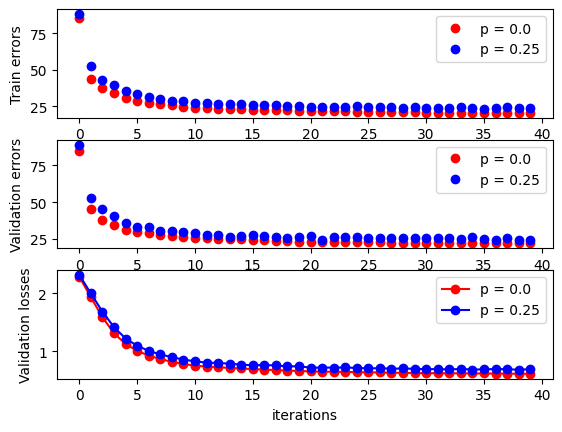

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(3,1)

markers = ['ro','bo']

for p, m in zip(dropout_params, markers):
    axs[0].plot(results[p]['train_errors'], m, label=f'p = {p}')
axs[0].set_ylabel('Train errors')
axs[0].legend()

for p, m in zip(dropout_params, markers):
    axs[1].plot(results[p]['val_errors'], m, label=f'p = {p}')
axs[1].set_ylabel('Validation errors')
axs[1].legend()

for p, m in zip(dropout_params, markers):
    axs[2].plot(results[p]['val_losses'], m+'-', label=f'p = {p}')
axs[2].set_xlabel('iterations')
axs[2].set_ylabel('Validation losses')
axs[2].legend()

### Batch Normalization Experiment (10 points)

Once again modify the `build_model` method to add a `BatchNormalization` layer before every `ReLU` layer. Train two networks - one with Batch Norm, and one without Batch Norm. Train them and visualize training loss curves. You should find that using batch normalization helps the network to converge much faster.


In [26]:
def build_model(input_size, hidden_sizes, output_size, activation_func='ReLU', bn=False):
    """
    Build the model:
    input_size: the dimension of input data
    hidden_sizes: the dimension of all hidden layers. Include as many hidden layers as are there in this list
    output_size: the output size of final layer.
    activation_func: ReLU
    bn: flag to enable or disable batch norm
    """

    model = Sequential()

    # Add the first hidden layer connected to the input
    model.add(FullyConnected(input_size, hidden_sizes[0]))
    if bn:
        model.add(BatchNormalization(inputSize=hidden_sizes[0]))
    if activation_func == 'ReLU':
        model.add(ReLU())

    # Add any additional hidden layers with BatchNormalization if specified
    for i in range(1, len(hidden_sizes)):
        model.add(FullyConnected(hidden_sizes[i-1], hidden_sizes[i]))
        if bn:
            model.add(BatchNormalization(inputSize=hidden_sizes[i]))
        if activation_func == 'ReLU':
            model.add(ReLU())

    # Output layer
    model.add(FullyConnected(hidden_sizes[-1], output_size))

    return model


In [27]:
# -- training options
trainopt = {
    'lr': .001,
    'maxiter': 20000,
    'display_iter': 500,
    'batch_size': 100,
    'lr_decay': .5,
    'lr_decay_interval': .25  #
}

NFEATURES = X_train.shape[1]
NCLASSES = 10
hidden_sizes = [500,500]
# Play around with choices of dropout probability
bn_params = [False, True]

results = {}

for b in bn_params:
    model = build_model(NFEATURES, hidden_sizes, NCLASSES, bn=b)
    criterion = SoftMaxLoss()

    print(f'Model with dropout parameter {p} has {model.size()} layers.')

    # -- model trained on large train set
    best_model, min_val_err, train_errors, val_errors, val_losses = train(model, criterion, X_train, y_train, X_val, y_val, trainopt)

    results['bn' if b else 'no_bn'] = {'model': best_model, 'train_errors': train_errors, 'val_errors': val_errors, 'val_losses': val_losses}


Model with dropout parameter 0.25 has 5 layers.
       0 batch loss: 2.323 train error: 95.325 val error: 95.600
     500 batch loss: 2.011 train error: 42.337 val error: 45.200
    1000 batch loss: 1.671 train error: 38.062 val error: 39.950
    1500 batch loss: 1.258 train error: 34.113 val error: 35.950
    2000 batch loss: 1.160 train error: 31.088 val error: 32.050
    2500 batch loss: 1.136 train error: 28.925 val error: 30.450
    3000 batch loss: 1.048 train error: 27.738 val error: 28.950
    3500 batch loss: 0.745 train error: 26.587 val error: 27.900
    4000 batch loss: 0.833 train error: 25.887 val error: 27.700
    4500 batch loss: 0.875 train error: 24.950 val error: 26.550
    5000 batch loss: 0.856 train error: 24.175 val error: 25.900
    5500 batch loss: 0.596 train error: 23.875 val error: 25.600
    6000 batch loss: 0.733 train error: 23.687 val error: 25.350
    6500 batch loss: 0.795 train error: 23.438 val error: 24.950
    7000 batch loss: 0.802 train error: 23

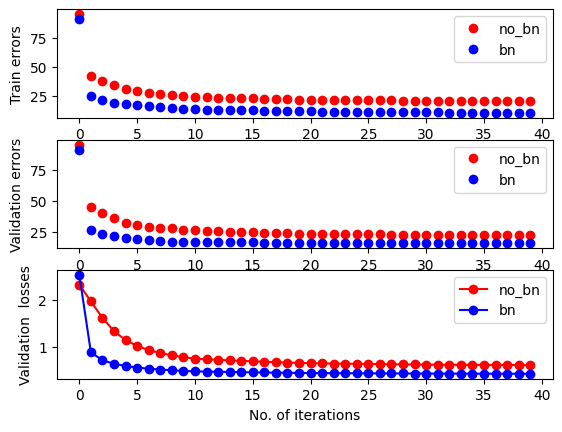

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(3,1)

markers = ['ro','bo']

for k, m in zip(results.keys(), markers):
    axs[0].plot(results[k]['train_errors'], m, label=k)
axs[0].set_ylabel('Train errors')
axs[0].legend()

for k, m in zip(results.keys(), markers):
    axs[1].plot(results[k]['val_errors'], m, label=k)
axs[1].set_ylabel('Validation errors')
axs[1].legend()

for k, m in zip(results.keys(), markers):
    axs[2].plot(results[k]['val_losses'], m+'-', label=k)
axs[2].set_xlabel('No. of iterations')
axs[2].set_ylabel('Validation  losses')
axs[2].legend()